# Setup

## Code

In [1]:
import warnings

import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, cohen_kappa_score, log_loss, matthews_corrcoef, roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Data

In [2]:
# load data
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [4]:
for cat_col in ['cut', 'color', 'clarity']:
    print(cat_col, '-', diamonds[cat_col].unique())

cut - ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
color - ['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity - ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']


In [5]:
# create global variable for unique classes
global CLASS_COL, CLASSES, N_CLASSES
CLASS_COL = 'cut'
CLASSES = list(diamonds[CLASS_COL].unique())
N_CLASSES = len(CLASSES)

In [6]:
# dependent variable is imbalanced
diamonds[CLASS_COL].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [7]:
# handle categorical variables: color, clarity 
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], dtype=int)], axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], dtype=int)], axis=1)
diamonds = diamonds.drop(['color', 'clarity'], axis=1)
diamonds.head()

,carat,cut,depth,table,price,x,y,z,D,E,...,I,J,IF,VVS1,VVS2,VS1,VS2,SI1,SI2,I1
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75,0,0,...,0,1,0,0,0,0,0,0,1,0


# Train Test Split

In [8]:
def train_test_imbalanced(df, test_size=0.3):
    """
    Train test splits maintains imbalance across classes
    
    Parameters
    ----------
    df : pandas DataFrame
    test_size : float, default 0.3
        Percent of df rows that will be in the test set

    Returns
    -------
    X_train : pands DataFrame
    X_test : pands DataFrame
    y_train : pands Series
    y_test : pands Series
    """
    X_cols = df.columns.drop(CLASS_COL)
    X_train_df, X_test_df = pd.DataFrame(columns=X_cols), pd.DataFrame(columns=X_cols)
    y_train_ser, y_test_ser = pd.Series(name=CLASS_COL), pd.Series(name=CLASS_COL)
    
    for class_val in CLASSES:
        df_by_class = df[df[CLASS_COL] == class_val]
        X_tr, X_te, y_tr, y_te = train_test_split(df_by_class[X_cols], df_by_class[CLASS_COL],
                                                  test_size=test_size, random_state=42)
        X_train_df = pd.concat([X_train_df, X_tr], ignore_index=True)
        X_test_df = pd.concat([X_test_df, X_te], ignore_index=True)
        y_train_ser = pd.concat([y_train_ser, y_tr], ignore_index=True)
        y_test_ser = pd.concat([y_test_ser, y_te], ignore_index=True)
    
    return X_train_df, X_test_df, y_train_ser, y_test_ser

In [9]:
def train_test_balanced(df, test_size=0.3):
    """
    Train test splits with balance across classes
    """
    total_sample_size = df[CLASS_COL].value_counts().sort_values()[0]
    
    X_cols = df.columns.drop(CLASS_COL)
    X_train_df, X_test_df = pd.DataFrame(columns=X_cols), pd.DataFrame(columns=X_cols)
    y_train_ser, y_test_ser = pd.Series(name=CLASS_COL), pd.Series(name=CLASS_COL)
    
    for class_val in CLASSES:
        df_by_class = df[df[CLASS_COL] == class_val].sample(total_sample_size)
        X_tr, X_te, y_tr, y_te = train_test_split(df_by_class[X_cols], df_by_class[CLASS_COL],
                                                  test_size=test_size, random_state=42)
        X_train_df = pd.concat([X_train_df, X_tr], ignore_index=True)
        X_test_df = pd.concat([X_test_df, X_te], ignore_index=True)
        y_train_ser = pd.concat([y_train_ser, y_tr], ignore_index=True)
        y_test_ser = pd.concat([y_test_ser, y_te], ignore_index=True)
    
    return X_train_df, X_test_df, y_train_ser, y_test_ser

In [10]:
X_train, X_test, y_train, y_test = train_test_imbalanced(diamonds)

/var/folders/md/tdm3bh116j3b_d_xp4v9gjmw0000gq/T/ipykernel_87895/1072647464.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train_ser, y_test_ser = pd.Series(name=CLASS_COL), pd.Series(name=CLASS_COL)
/var/folders/md/tdm3bh116j3b_d_xp4v9gjmw0000gq/T/ipykernel_87895/1072647464.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train_ser, y_test_ser = pd.Series(name=CLASS_COL), pd.Series(name=CLASS_COL)


# Train and Predict

In [11]:
# knn
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)

In [12]:
# naive bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [13]:
# svc
svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [14]:
# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [15]:
# predictions and their probabilities
y_preds = {
    'kNN': y_pred_knn,
    'Gaussian Naive Bayes': y_pred_nb,
    'SVC': y_pred_svc,
    'Random Forest': y_pred_rf
}
y_pred_probas = {
    'kNN': knn.predict_proba(X_test),
    'Gaussian Naive Bayes': nb.predict_proba(X_test),
    'SVC': svc.predict_proba(X_test),
    'Random Forest': rf.predict_proba(X_test)
}

We use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion. This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).

In [16]:
# one-hot encode test outcome variable
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Classification Evaluation

- confusion matrix
- type 1 (FP) and 2 error (FN)

In [17]:
# helper function
def arr_division(arr1, arr2):
    """Handles divide by 0 errors by replacing with 0 and casts"""
    return np.divide(arr1.astype(np.float32), arr2.astype(np.float32),
                     out=np.zeros_like(arr1.astype(np.float32)), where=arr2!=0)

In [18]:
def classification_counts(cm):
    """
    Takes a confusion matrix and calculates relevant counts and ratios
    
    Parameters
    ----------
    cm : ndarray of shape (n_classes, n_classes)
        Confusion matrix

    Returns
    -------
    counts : pands DataFrame
        Contains support, tp, fp, fn, tn
    ratios : pands DataFrame
        Contains accuracy, recall, specificity, precision, npv, and f1 score
    """
    # counts
    SUP = cm.sum(axis=1)
    TP = np.diag(cm)
    FP = (cm.sum(axis=0) - TP)
    FN = (SUP - TP)
    TN = (cm.sum() - (FP + FN + TP))
    counts = pd.DataFrame(np.array([SUP, TP, FP, FN, TN]).T,
                          columns=['Support', 'TP', 'FP', 'FN', 'TN'], index=CLASSES)

    # ratios
    TPR = arr_division(TP, TP + FN) # recall, sensitivity, hit rate, true positive rate, TPR
    TNR = arr_division(TN, TN + FP) # specificity, true negative rate, TNR
    PPV = arr_division(TP, TP + FP) # precision, positive predictive value, PPV
    NPV = arr_division(TN, TN + FN) # negative predictive value, NPV
    ACC = arr_division(TP + TN, TP + FP + FN + TN) # accuracy
    F1 = arr_division(2 * PPV * TPR, PPV + TPR) # f1 score = (2 * precision * recall) / (precision + recall)

    ratios_cols = [
        'Accuracy', 'Recall', 'Specificity',
        'Precision', 'NPV', 'F1 Score'
    ]
    ratios_index = np.concatenate((CLASSES, np.array(['Macro Avg', 'Micro Avg'])))
    ratios_arr = np.array([ACC, TPR, TNR, PPV, NPV, F1]).T
    macro_avg = np.array([ratios_arr.sum(axis=0) / N_CLASSES])
    micro_avg = np.array([(ratios_arr * np.array([SUP]).T / SUP.sum()).sum(axis=0)])
    ratios = pd.DataFrame(np.concatenate((ratios_arr, macro_avg, micro_avg)),
                          columns=ratios_cols, index=ratios_index)

    return counts, ratios

In [19]:
def classification_summary_stats(y_true, y_pred, y_pred_proba=None):
    """
    Calculates Cohen's Kappa, MCC, and optionally Cross-Entropy Loss
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True values
    y_pred : array-like of shape (n_samples,)
        Predicted values
    y_pred_proba : ndarray of shape (n_samples, n_classes), default None
        Predicted probabilities for each example and class
        If passed, Cross-Entropy Loss will be included in the output

    Returns
    -------
    evals_df : pands DataFrame
        Contains Cohen's Kappa, MCC, and optionally Cross-Entropy Loss
    """
    evals_cols = ["Cohen's Kappa", 'Mathews Correlation Coefficient']
    evals_list = [
        cohen_kappa_score(y_true, y_pred),
        matthews_corrcoef(y_true, y_pred)
    ]
    if y_pred_proba is not None:
        evals_cols.append('Cross Entropy')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            evals_list.append(log_loss(y_true, y_pred_proba))

    evals_df = pd.DataFrame(np.array([evals_list]), columns=evals_cols)
    return evals_df

In [20]:
def roc_auc_plot_data(y_onehot_true, y_pred_proba):
    """
    Calculates Cohen's Kappa, MCC, and optionally Cross-Entropy Loss
    
    Parameters
    ----------
    y_onehot_true : ndarray of shape (n_samples, n_classes)
        One-hot endcoded true values
    y_pred_proba : ndarray of shape (n_samples, n_classes)
        Predicted probabilities for each example and class

    Returns
    -------
    fpr : pands DataFrame
        False positive rates for each class, also macro and micro averaged
    tpr : pands DataFrame
        True positive rates for each class, also macro and micro averaged
    roc_auc : pands DataFrame
        AUC values for each class, also macro and micro averaged
    """
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    # micro-average
    fpr['micro'], tpr['micro'], _ = roc_curve(y_onehot_true.ravel(), y_pred_proba.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # iterate through classes
    for i, class_val in enumerate(CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_true[:, i], y_pred_proba[:, i])
        roc_auc[class_val] = auc(fpr[i], tpr[i])
    
    # linear interpolation
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)
    for i in range(N_CLASSES):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
    mean_tpr /= N_CLASSES

    # macro-average
    fpr['macro'] = fpr_grid
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    
    return fpr, tpr, roc_auc

In [21]:
def roc_auc_plot(y_onehot_true, y_pred_proba, model_name):
    """
    Plots ROC Curve and prints AUC values
    
    Parameters
    ----------
    y_onehot_true : ndarray of shape (n_samples, n_classes)
        One-hot endcoded true values
    y_pred_proba : ndarray of shape (n_samples, n_classes)
        Predicted probabilities for each example and class
    model_name : string
        Name of the model
    """
    fpr, tpr, roc_auc_scores = roc_auc_plot_data(y_onehot_true, y_pred_proba)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(
        fpr['micro'],
        tpr['micro'],
        label=f"micro-average ROC curve (AUC = {roc_auc_scores['micro']:.2f})",
        linestyle=':',
        linewidth=4
    )
    ax.plot(
        fpr['macro'],
        tpr['macro'],
        label=f"macro-average ROC curve (AUC = {roc_auc_scores['macro']:.2f})",
        linestyle=':',
        linewidth=4
    )
    
    for i in range(N_CLASSES):
        RocCurveDisplay.from_predictions(
            y_onehot_true[:, i],
            y_pred_proba[:, i],
            name=f"ROC curve for {CLASSES[i]}",
            ax=ax,
            plot_chance_level=(i == 2)
        )
    
    ax.set_title(f"ROC for {model_name}")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.show()

    df = pd.DataFrame(roc_auc_scores, index=[model_name])
    print(f"AUC for {model_name}")
    print(tabulate(df, headers='keys', floatfmt='.4f', tablefmt='rounded_outline'))

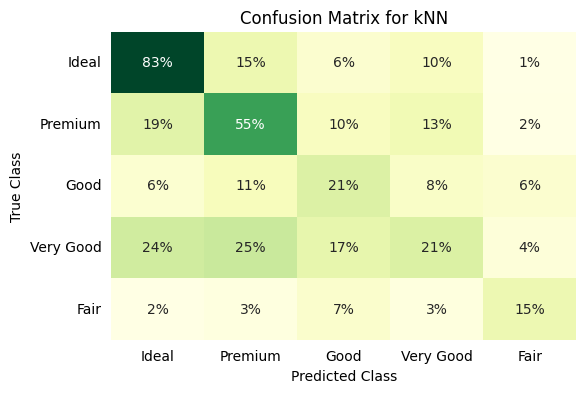

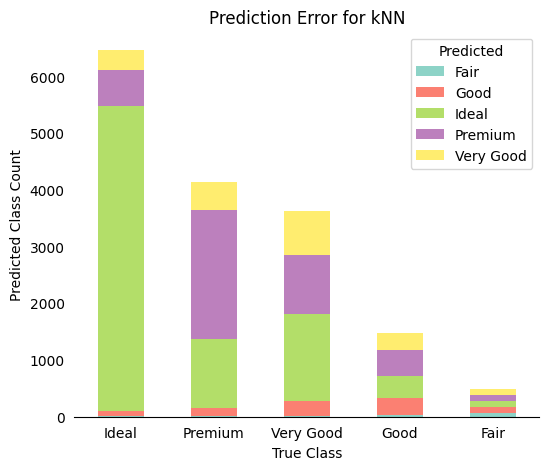


Counts for kNN
╭───────────┬───────────┬──────┬──────┬──────┬───────╮
│           │   Support │   TP │   FP │   FN │    TN │
├───────────┼───────────┼──────┼──────┼──────┼───────┤
│ Ideal     │      6466 │ 5389 │ 3245 │ 1077 │  6473 │
│ Premium   │      4138 │ 2288 │ 2228 │ 1850 │  9818 │
│ Good      │      1472 │  305 │  592 │ 1167 │ 14120 │
│ Very Good │      3625 │  769 │ 1234 │ 2856 │ 11325 │
│ Fair      │       483 │   71 │   63 │  412 │ 15638 │
╰───────────┴───────────┴──────┴──────┴──────┴───────╯


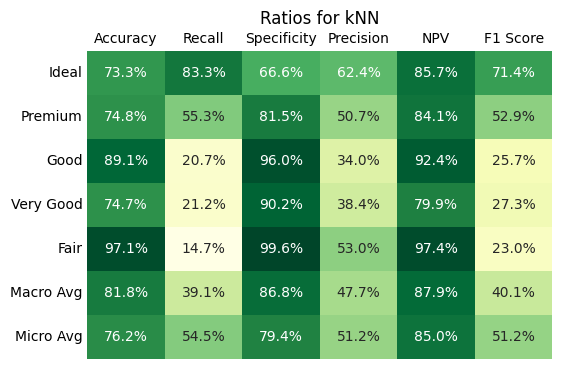

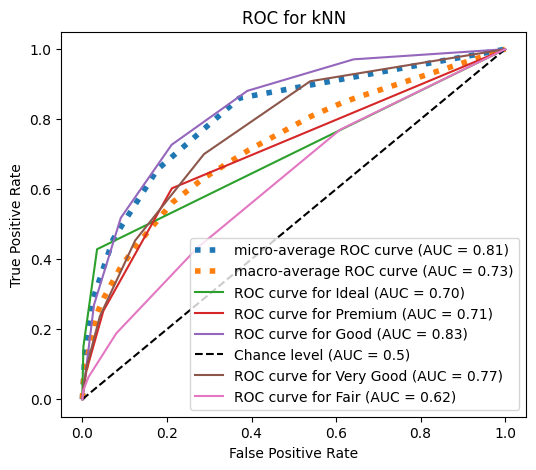

AUC for kNN
╭─────┬─────────┬─────────┬───────────┬────────┬─────────────┬────────┬─────────╮
│     │   micro │   Ideal │   Premium │   Good │   Very Good │   Fair │   macro │
├─────┼─────────┼─────────┼───────────┼────────┼─────────────┼────────┼─────────┤
│ kNN │  0.8123 │  0.6991 │    0.7081 │ 0.8336 │      0.7705 │ 0.6170 │  0.7257 │
╰─────┴─────────┴─────────┴───────────┴────────┴─────────────┴────────┴─────────╯

Summary Stats for kNN
╭─────────────────┬───────────────────────────────────┬─────────────────╮
│   Cohen's Kappa │   Mathews Correlation Coefficient │   Cross Entropy │
├─────────────────┼───────────────────────────────────┼─────────────────┤
│          0.3335 │                            0.3419 │          5.6659 │
╰─────────────────┴───────────────────────────────────┴─────────────────╯


In [22]:
def one_classification_eval(y_true, y_pred, y_pred_proba, y_onehot_true, model_name):
    """
    Evaluates a single multi-class classifier

    arameters
    ----------
    y_true : array-like of shape (n_samples,)
        True values
    y_pred : array-like of shape (n_samples,)
        Predicted values
    y_pred_proba : ndarray of shape (n_samples, n_classes)
        Predicted probabilities for each example and class
        If passed, Cross-Entropy Loss will be included in the output
    y_onehot_true : ndarray of shape (n_samples, n_classes)
        One-hot endcoded true values
    model_name : string
        Name of the model
    """
    cm = confusion_matrix(y_true, y_pred, labels=CLASSES)
    counts, ratios = classification_counts(cm)
    summary_stats = classification_summary_stats(y_true, y_pred, y_pred_proba)
    cm_pct = cm / cm.sum(axis=1)

    # plot pct confusion matrix heatmap
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(pd.DataFrame(cm_pct, columns=CLASSES, index=CLASSES),
                cmap='YlGn', annot=True, cbar=False, fmt='.0%')
    if model_name:
        ax.set_title(f"Confusion Matrix for {model_name}")
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.tick_params(axis='both', left=False, bottom=False)
    ax.set_yticklabels(CLASSES, rotation=0)
    plt.show()

    # plot prediction error chart
    fig, ax = plt.subplots(figsize=(6,5))
    df = pd.DataFrame(y_true).rename({CLASS_COL: ''}, axis=1)
    df['Predicted'] = y_pred
    df.groupby(['', 'Predicted']) \
        .size() \
        .unstack() \
        .plot(kind='bar', stacked=True, colormap='Set3', ax=ax, rot=0)
    
    if model_name:
        ax.set_title(f"Prediction Error for {model_name}")
    ax.set_xlabel('True Class')
    ax.set_ylabel('Predicted Class Count')
    ax.tick_params(axis='both', left=False, bottom=False)
    for spine_location in ['top', 'left', 'right']:
        ax.spines[spine_location].set_visible(False)
    plt.show()

    # print counts
    if model_name:
        print(f"\nCounts for {model_name}")
    print(tabulate(counts, headers='keys', floatfmt='.0f', tablefmt='rounded_outline'))

    # plot ratios heatmap
    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(ratios, ax=ax, cmap='YlGn', annot=True, cbar=False, fmt='.1%')
    if model_name:
        ax.set_title(f"Ratios for {model_name}")
    ax.tick_params(axis='both', length=0, left=False, bottom=False)
    ax.xaxis.tick_top()
    plt.show()

    # plot and print roc auc
    if isinstance(y_onehot_true, np.ndarray):
        roc_auc_plot(y_onehot_true, y_pred_proba, model_name)

    # print summary stats
    ss_df = classification_summary_stats(y_true, y_pred, y_pred_proba)
    if model_name:
        print(f"\nSummary Stats for {model_name}")
    print(tabulate(ss_df, headers='keys', floatfmt='.4f', tablefmt='rounded_outline',
                   showindex=False))


one_classification_eval(y_test, y_pred_knn, y_pred_proba=knn.predict_proba(X_test), y_onehot_true=y_onehot_test, model_name='kNN')

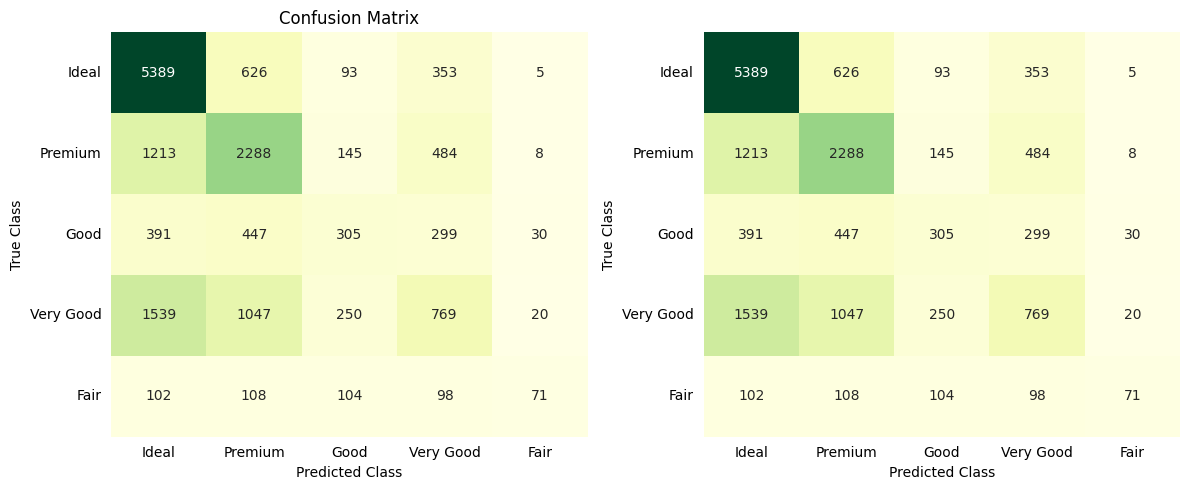

In [23]:
# for medium article
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=CLASSES)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.heatmap(pd.DataFrame(cm_knn, columns=CLASSES, index=CLASSES),
            ax=axs[0], cmap='YlGn', annot=True, cbar=False, fmt='.0f')
axs[0].set_title('Confusion Matrix')
axs[0].set_xlabel('Predicted Class')
axs[0].set_ylabel('True Class')
axs[0].set_yticklabels(CLASSES, rotation=0)
axs[0].tick_params(axis='both', left=False, bottom=False)

sns.heatmap(pd.DataFrame(cm_knn, columns=CLASSES, index=CLASSES),
            ax=axs[1], cmap='YlGn', annot=True, cbar=False, fmt='.0f')
axs[1].set_xlabel('Predicted Class')
axs[1].set_ylabel('True Class')
axs[1].set_yticklabels(CLASSES, rotation=0)
axs[1].tick_params(axis='both', left=False, bottom=False)

plt.tight_layout()
plt.show()

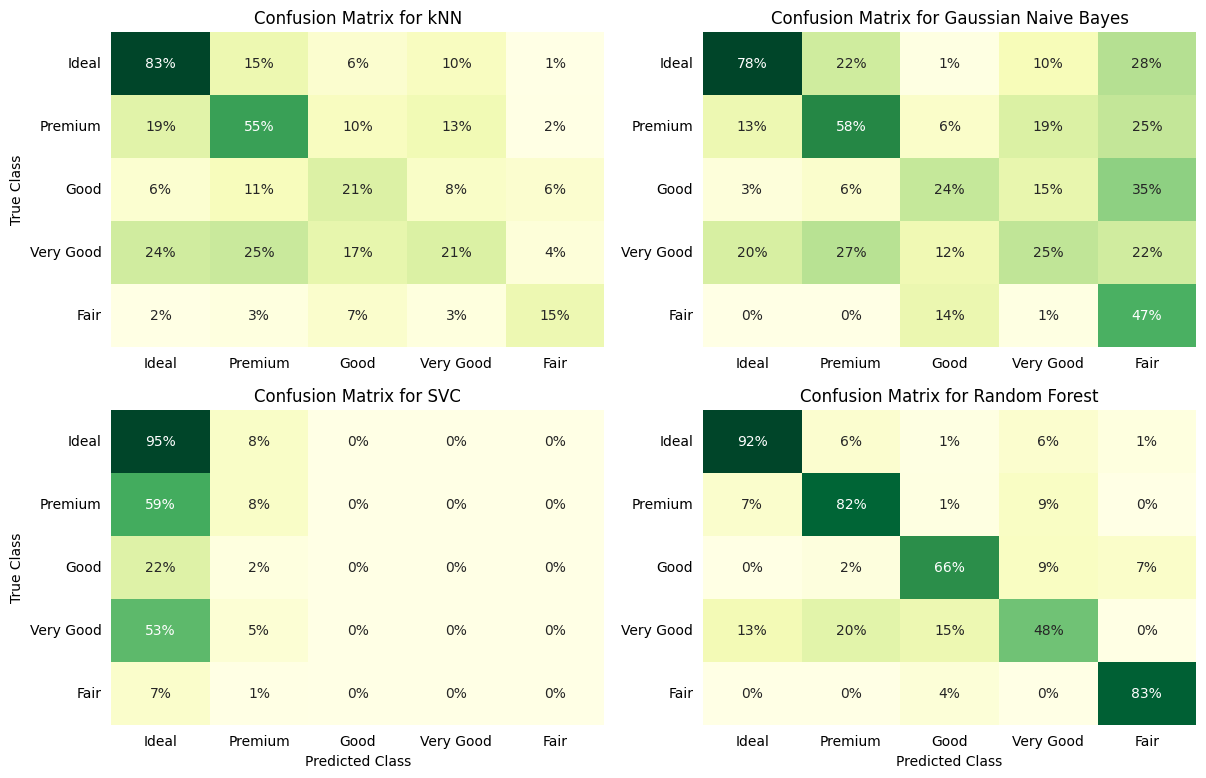

In [24]:
# confusion matrix
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,9))

for i, (model_name, y_pred) in enumerate(y_preds.items()):
    x = int(i / 2)
    y = 1 if i % 2 > 0 else 0
    cm = confusion_matrix(y_test, y_pred, labels=CLASSES)
    cm_pct = cm / cm.sum(axis=1)
    
    sns.heatmap(pd.DataFrame(cm_pct, columns=CLASSES, index=CLASSES),
                ax=axs[x,y], cmap='YlGn', annot=True, cbar=False, fmt='.0%')
    axs[x,y].set_title(f"Confusion Matrix for {model_name}")
    if x > 0:
        axs[x,y].set_xlabel('Predicted Class')
    if y == 0:
        axs[x,y].set_ylabel('True Class')
    axs[x,y].tick_params(axis='both', left=False, bottom=False)
    axs[x,y].set_yticklabels(CLASSES, rotation=0)

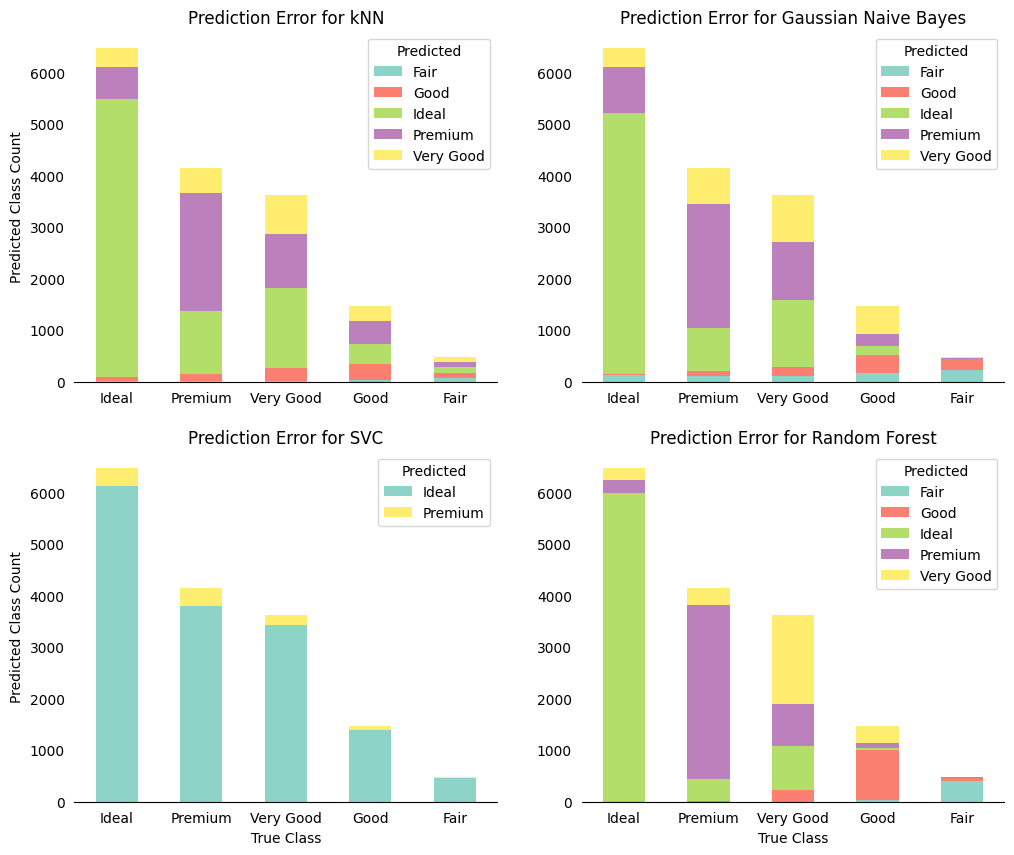

In [25]:
# prediction error
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, (model_name, y_pred) in enumerate(y_preds.items()):
    x = int(i / 2)
    y = 1 if i % 2 > 0 else 0
    
    df = pd.DataFrame(y_test).rename({CLASS_COL: ''}, axis=1)
    df['Predicted'] = y_pred
    df.groupby(['', 'Predicted']) \
        .size() \
        .unstack() \
        .plot(kind='bar', stacked=True, colormap='Set3', ax=axs[x,y], rot=0)
    
    axs[x,y].set_title(f"Prediction Error for {model_name}")
    if x > 0:
        axs[x,y].set_xlabel('True Class')
    if y == 0:
        axs[x,y].set_ylabel('Predicted Class Count')
    axs[x,y].tick_params(axis='both', left=False, bottom=False)
    for spine_location in ['top', 'left', 'right']:
        axs[x,y].spines[spine_location].set_visible(False)

In [26]:
# counts
for model_name, y_pred in y_preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=CLASSES)
    counts, _ = classification_counts(cm)
    print(f"\nCounts for {model_name}")
    print(tabulate(counts, headers='keys', floatfmt='.0f', tablefmt='rounded_outline'))


Counts for kNN
╭───────────┬───────────┬──────┬──────┬──────┬───────╮
│           │   Support │   TP │   FP │   FN │    TN │
├───────────┼───────────┼──────┼──────┼──────┼───────┤
│ Ideal     │      6466 │ 5389 │ 3245 │ 1077 │  6473 │
│ Premium   │      4138 │ 2288 │ 2228 │ 1850 │  9818 │
│ Good      │      1472 │  305 │  592 │ 1167 │ 14120 │
│ Very Good │      3625 │  769 │ 1234 │ 2856 │ 11325 │
│ Fair      │       483 │   71 │   63 │  412 │ 15638 │
╰───────────┴───────────┴──────┴──────┴──────┴───────╯

Counts for Gaussian Naive Bayes
╭───────────┬───────────┬──────┬──────┬──────┬───────╮
│           │   Support │   TP │   FP │   FN │    TN │
├───────────┼───────────┼──────┼──────┼──────┼───────┤
│ Ideal     │      6466 │ 5056 │ 2313 │ 1410 │  7405 │
│ Premium   │      4138 │ 2395 │ 2270 │ 1743 │  9776 │
│ Good      │      1472 │  353 │  494 │ 1119 │ 14218 │
│ Very Good │      3625 │  920 │ 1628 │ 2705 │ 10931 │
│ Fair      │       483 │  228 │  527 │  255 │ 15174 │
╰───────────┴───

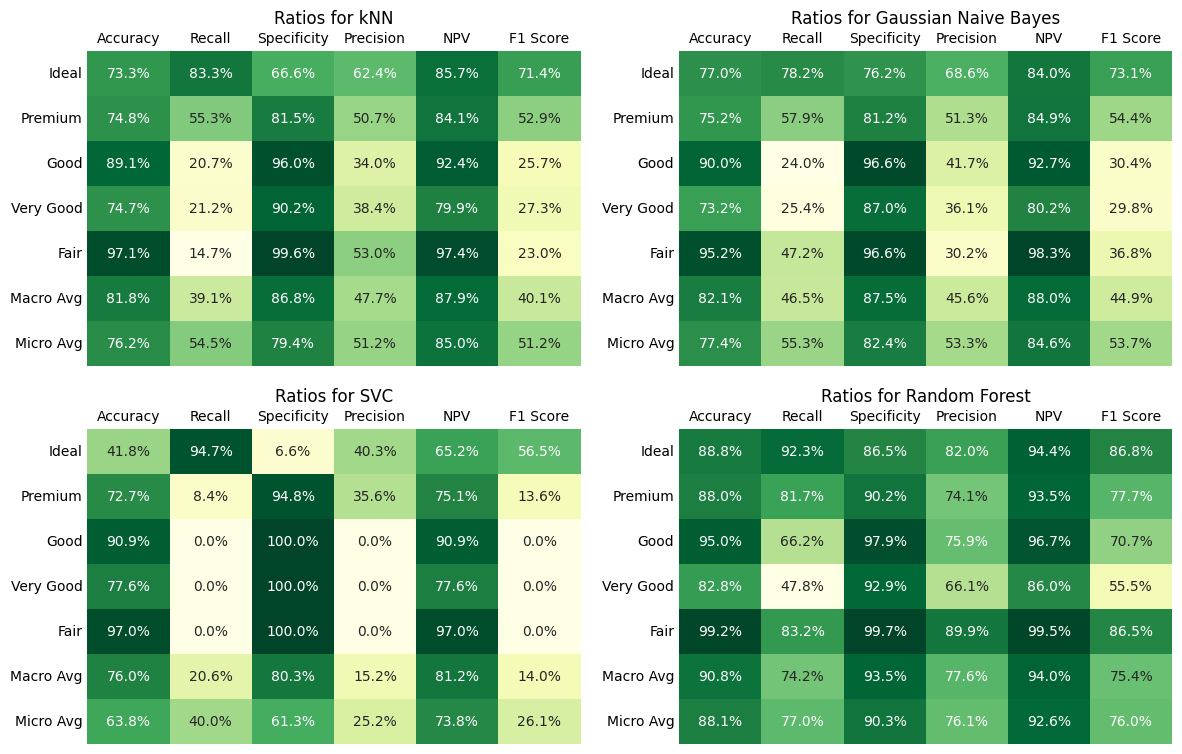

In [27]:
# ratios
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,9))

for i, (model_name, y_pred) in enumerate(y_preds.items()):
    x = int(i / 2)
    y = 1 if i % 2 > 0 else 0
    cm = confusion_matrix(y_test, y_pred, labels=CLASSES)
    _, ratios = classification_counts(cm)
    
    sns.heatmap(ratios, ax=axs[x,y], cmap='YlGn', annot=True, cbar=False, fmt='.1%')
    axs[x,y].set_title(f"Ratios for {model_name}")
    axs[x,y].tick_params(axis='both', length=0, left=False, bottom=False)
    axs[x,y].xaxis.tick_top()

In [28]:
# summary stats
summary_stats_df = pd.DataFrame()

for model_name, y_pred in y_preds.items():
    ss_df = classification_summary_stats(y_test, y_pred,
                                         y_pred_proba=y_pred_probas[model_name])
    ss_df['Model'] = model_name
    summary_stats_df = pd.concat([summary_stats_df, ss_df])

print(tabulate(summary_stats_df.set_index('Model'), headers='keys', floatfmt='.4f', tablefmt='rounded_outline'))

╭──────────────────────┬─────────────────┬───────────────────────────────────┬─────────────────╮
│ Model                │   Cohen's Kappa │   Mathews Correlation Coefficient │   Cross Entropy │
├──────────────────────┼─────────────────┼───────────────────────────────────┼─────────────────┤
│ kNN                  │          0.3335 │                            0.3419 │          5.6659 │
│ Gaussian Naive Bayes │          0.3643 │                            0.3671 │          1.4236 │
│ SVC                  │          0.0151 │                            0.0323 │          1.2444 │
│ Random Forest        │          0.6727 │                            0.6763 │          0.7016 │
╰──────────────────────┴─────────────────┴───────────────────────────────────┴─────────────────╯


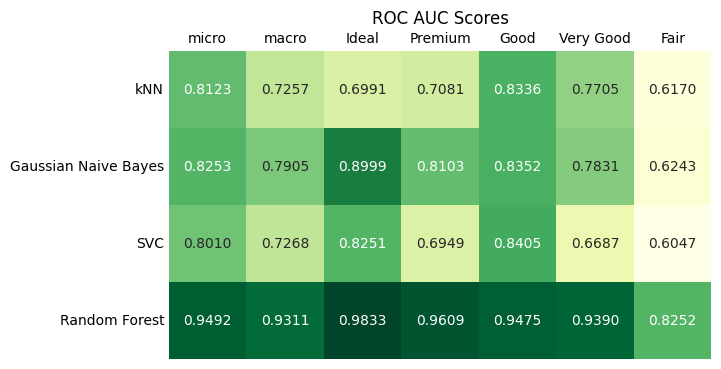

In [29]:
roc_auc_df = pd.DataFrame()
for model_name, y_pred_proba in y_pred_probas.items():
    _, _, roc_auc_scores = roc_auc_plot_data(y_onehot_test, y_pred_proba)
    columns, values = zip(*roc_auc_scores.items())
    this_class_df = pd.DataFrame([values], columns=columns, index=[model_name])
    roc_auc_df = pd.concat([roc_auc_df, this_class_df])

roc_auc_df = roc_auc_df[['micro', 'macro'] + CLASSES]

fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(roc_auc_df, ax=ax, cmap='YlGn', annot=True, cbar=False, fmt='.4f')
ax.set_title('ROC AUC Scores')
ax.set_yticklabels(roc_auc_df.index, rotation=0)
ax.tick_params(axis='both', length=0, left=False, bottom=False)
ax.xaxis.tick_top()

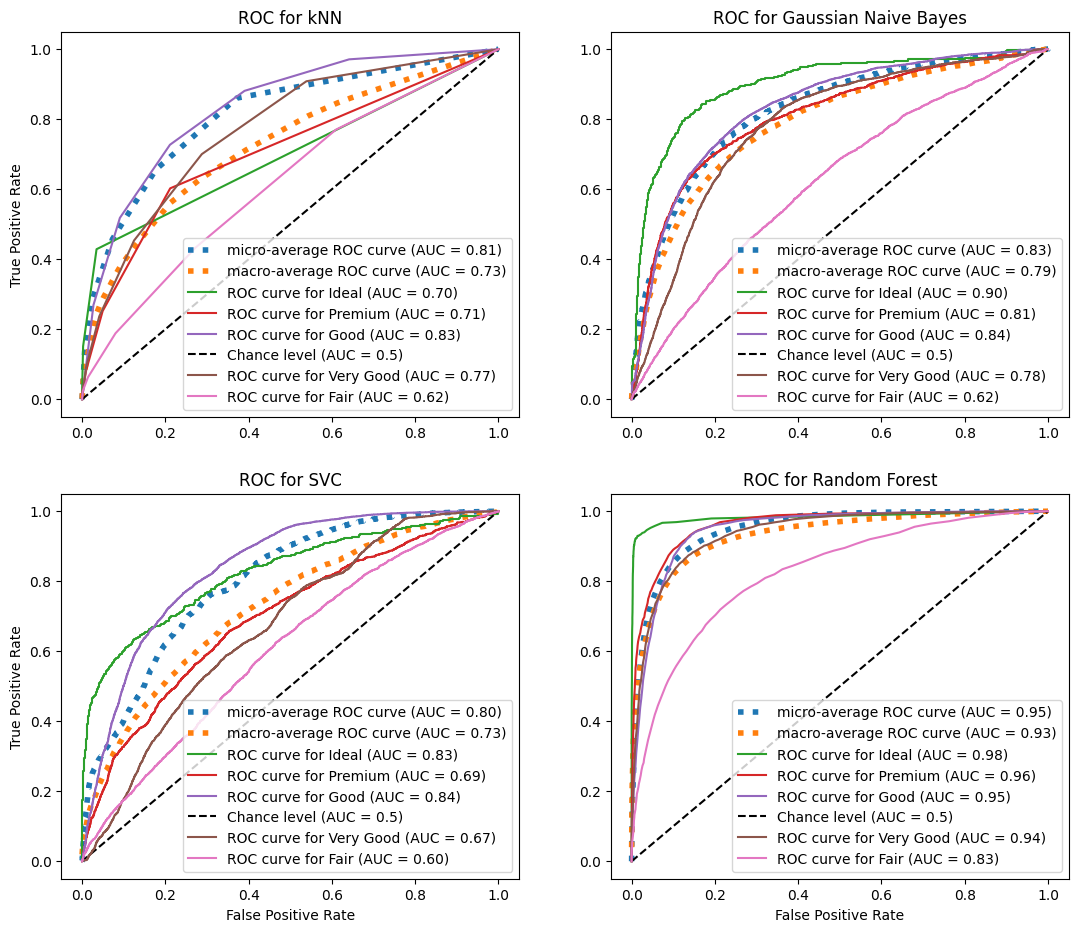

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 11))

for i, (model_name, y_pred_proba) in enumerate(y_pred_probas.items()):
    x = int(i / 2)
    y = 1 if i % 2 > 0 else 0

    fpr, tpr, roc_auc_scores = roc_auc_plot_data(y_onehot_test, y_pred_proba)
    
    axs[x,y].plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc_scores['micro']:.2f})",
        linestyle=":",
        linewidth=4
    )
    
    axs[x,y].plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc_scores['macro']:.2f})",
        linestyle=":",
        linewidth=4,
    )
    
    for i in range(N_CLASSES):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, i],
            y_pred_proba[:, i],
            name=f"ROC curve for {CLASSES[i]}",
            ax=axs[x,y],
            plot_chance_level=(i == 2),
        )
    
    axs[x,y].set_title(f"ROC for {model_name}")
    if x > 0:
        axs[x,y].set_xlabel('False Positive Rate')
    else:
        axs[x,y].set_xlabel('')
    if y == 0:
        axs[x,y].set_ylabel('True Positive Rate')
    else:
        axs[x,y].set_ylabel('')

In [31]:
# cross-entropy log loss https://medium.com/@l228104/understanding-cross-entropy-loss-and-its-role-in-classification-problems-d2550f2caad5